# CIC Subpopulation Construction

To create a representative model of the agent interactions, we will use subpopulation modeling. We take all of the agents and cluster them based off of the following features from full population actual transactional data from Jan - May 11 2020 xDai data (s means source, t means target):
* s_location - source individual location
* s_business_type - source individual business type
* t_location - target individual location
* t_business_type - target individual business type.
* weight, which is tokens, exchange amount
* s_bal - source individual CIC wallet balance
* t_bal - target individual CIC wallet balance

Essentially, we are taking a graph zoom operation, bundling nodes together based off of their likeness. Nodes are constant with edges being transative. The algorithm we use for this graph zoom operation is Kmeans clustering. Based off our descriptive statistical analysis and use of th Gap Statistic created by Stanford researchers Tibshirani, Walther and Hastie in their 2001 [paper](https://web.stanford.edu/~hastie/Papers/gap.pdf), we determined 50 clusters are representative of the subpopulations. All of the flows inside of the bundle become part of the self-loop flow. For example, within cluster 1, agent a can transaction with as b. This will not be reflected within our model as this is intra not inter cluster interactions.
 
## Graph Model of Current Spend Activity

We created a network graph of the CIC transaction data as a $G(N,E)$ weighted directed graph with source and target agents as nodes, $N$ and the edges as $E$. Tokens are used as the edge weight to denote the actual CIC flow between agents, as $i,j \in E$.

The observed data shows the actual payments between network actors that are transacting in CIC. The observed data does not show us shillings payments between actors, actors utility, or demand. We only know actual CIC spends between agents.     


## Saving Clustering Results
At the bottom of this notebook, we calculate the median, 1st quartile, 3rd quartile, mean, standard deviation, utility types ordering, and utility types probability. These values can then be copied into the ```subpopulation_clusters.py``` in the simulation folders for use in the simulations.

In [14]:
# import libraries
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from gap_statistic import OptimalK
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

## Data Dump as of 5-15-2020
Jan - May 11 2020 xDai Blockchain data
https://www.grassrootseconomics.org/research

In [2]:
# import the data
transactions = pd.read_csv('data/sarafu_xDAI_tx_all_pub_all_time_12May2020.csv')
users = pd.read_csv('data/sarafu_xDAI_users_all_pub_all_time_12May2020.csv')

In [3]:
transactions.head()

,id,timeset,transfer_subtype,source,s_gender,s_location,s_business_type,target,t_gender,t_location,t_business_type,tx_token,weight,type,token_name,token_address
0,1,2020-01-25 19:13:17.731529,DISBURSEMENT,0xBDB3Bc887C3b70586BC25D04d89eC802b897fC5F,NaN,None,System,0x245fc81fe385450Dc0f4787668e47c903C00b0A1,female,GE Office,Savings Group,NaN,18000.000000,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4
1,2,2020-01-25 19:13:19.056070,DISBURSEMENT,0xBDB3Bc887C3b70586BC25D04d89eC802b897fC5F,NaN,None,System,0xC1697C1326fD192438515fE2F7E4cCb0C705C5d2,male,GE Nairobi,Farming/Labour,NaN,9047.660892,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4
2,3,2020-01-25 19:13:20.288346,DISBURSEMENT,0xBDB3Bc887C3b70586BC25D04d89eC802b897fC5F,NaN,None,System,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,male,GE Nairobi,Farming/Labour,NaN,25378.726002,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4
3,4,2020-01-25 19:13:21.478850,DISBURSEMENT,0xBDB3Bc887C3b70586BC25D04d89eC802b897fC5F,NaN,None,System,0xD95954e3fCd2f09A6Be5931D24f731eFa63BF435,male,G.E,Farming/Labour,NaN,4495.932576,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4
4,5,2020-01-26 07:48:43.042684,DISBURSEMENT,0xBDB3Bc887C3b70586BC25D04d89eC802b897fC5F,NaN,None,System,0x4AB73CfaC1732a9DcD74BdB4C9605f21832D7C72,male,Home,Farming/Labour,NaN,400.000000,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4


In [4]:
transactions.transfer_subtype.value_counts(normalize=True).to_dict()

{'STANDARD': 0.5085207861177824,
 'DISBURSEMENT': 0.35574873997902784,
 'RECLAMATION': 0.13483070053783444,
 'AGENT_OUT': 0.0008997733653553429}

Based on the data dictionary provided by Grassroots Economics, we know that the transfer subtype codes are:

* DISBURSEMENT = from Grassroots Economics
* RECLAMATION = Back to GE, 
* STANDARD = a trade between users, 
* AGENT = when a group account is cashing out


For purposes of our analysis, we will subset to STANDARD transactions. 

In [3]:
transactions_subset = transactions[transactions['transfer_subtype'] == 'STANDARD']
transactions_subset = transactions_subset[transactions_subset['token_name']=='Sarafu']

In [6]:
users.head()

,id,start,label,gender,location,held_roles,business_type,bal,xDAI_blockchain_address,confidence,...,otxns_in,otxns_out,ounique_in,ounique_out,svol_in,svol_out,stxns_in,stxns_out,sunique_in,sunique_out
0,1,2020-01-25 19:10:50.218686,1,NaN,None,ADMIN,System,8.916761e+06,0xBDB3Bc887C3b70586BC25D04d89eC802b897fC5F,0.000000,...,19917,52610,9,19862,0.0,0.0,0,0,0,0
1,2,2018-10-23 09:09:58,2,female,GE Office,TOKEN_AGENT,Savings Group,1.800000e+05,0x245fc81fe385450Dc0f4787668e47c903C00b0A1,0.000000,...,134,16,68,0,0.0,0.0,0,0,0,0
2,3,2018-10-21 14:20:57,3,male,GE Nairobi,BENEFICIARY,Farming/Labour,5.666089e+01,0xC1697C1326fD192438515fE2F7E4cCb0C705C5d2,0.000000,...,2,2,1,0,0.0,9007.0,0,1,0,1
3,4,2018-10-21 15:38:30,4,male,GE Nairobi,BENEFICIARY,Farming/Labour,1.173773e+04,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,0.100000,...,6,1,1,0,20619.0,50449.0,20,15,11,5
4,5,2018-10-23 14:10:27,5,male,G.E,BENEFICIARY,Farming/Labour,7.297263e+03,0xD95954e3fCd2f09A6Be5931D24f731eFa63BF435,0.405063,...,15,1,1,0,127393.3,168905.0,158,208,84,65


In [4]:
users['business_type'].value_counts(normalize=True).to_dict()

{'Farming/Labour': 0.43367860016090104,
 'Food/Water': 0.22863032984714401,
 'Shop': 0.1406878519710378,
 'Fuel/Energy': 0.06365647626709574,
 'None': 0.0621983105390185,
 'Transport': 0.04379525341914722,
 'Education': 0.014380530973451327,
 'Savings Group': 0.006335478680611424,
 'Health': 0.00331858407079646,
 'Environment': 0.001910699919549477,
 'System': 0.0012067578439259854,
 'Staff': 0.00010056315366049879,
 'Chama': 5.0281576830249393e-05,
 'Game': 5.0281576830249393e-05}

## Combine user and transaction tables

Combine user and transaction tables on both the source and target features.

In [5]:
user_subset = users[['bal','xDAI_blockchain_address']]

In [6]:
transactions_subset

,id,timeset,transfer_subtype,source,s_gender,s_location,s_business_type,target,t_gender,t_location,t_business_type,tx_token,weight,type,token_name,token_address
72647,170140,2020-04-30 10:43:45.170528,STANDARD,0xC1697C1326fD192438515fE2F7E4cCb0C705C5d2,male,GE Nairobi,Farming/Labour,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,male,GE Nairobi,Farming/Labour,NaN,9007.0,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4
72648,10,2020-01-26 08:26:22.521902,STANDARD,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,male,GE Nairobi,Farming/Labour,0x4AB73CfaC1732a9DcD74BdB4C9605f21832D7C72,male,Home,Farming/Labour,NaN,100.0,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4
72649,11,2020-01-26 08:27:26.757372,STANDARD,0xD95954e3fCd2f09A6Be5931D24f731eFa63BF435,male,G.E,Farming/Labour,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,male,GE Nairobi,Farming/Labour,NaN,2.0,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4
72650,13,2020-01-26 08:32:05.154096,STANDARD,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,male,GE Nairobi,Farming/Labour,0x4AB73CfaC1732a9DcD74BdB4C9605f21832D7C72,male,Home,Farming/Labour,NaN,23.0,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4
72651,15,2020-01-26 08:38:42.186525,STANDARD,0x4AfD04b9eD17759B362c8C929207Fe7ad81C39d3,male,Test,Health,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,male,GE Nairobi,Farming/Labour,NaN,12.0,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147810,208035,2020-05-11 08:52:34.504171,STANDARD,0x97F5165b544e0869ba3Be80D7eEe8b73a0270Dfe,Unknown gender,kilibole,Farming/Labour,0x5CAaA1f7dC13235Fe181D0307e682c387e75a6ec,Unknown gender,Kilibole,Food/Water,NaN,20.0,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4
147811,208021,2020-05-11 08:49:20.768559,STANDARD,0x9a05d12df366cE3aa1420c6DFFD0db9ce4ba77Fc,Unknown gender,Kikomani,Food/Water,0xb44279a1d11A2bc4b1b3D08D3BEAb8278cc86985,Unknown gender,Bofu,Shop,NaN,350.0,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4
147812,208459,2020-05-11 10:11:18.699013,STANDARD,0x2e44845BE57687bFdcdd26044bB7CdD575781336,male,Miyani,Shop,0xfCF20a412eB6DD345237C7BEeBab53B424b98297,male,Miyani,Shop,NaN,400.0,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4
147813,208395,2020-05-11 10:01:04.805823,STANDARD,0xAc4DB7728940e76BCd98Bb8E60671916f3B7576A,male,Kilifi,Farming/Labour,0x2f99a653F5dc201eA97578A6a203BC4db1eaD2FF,Unknown gender,KIlifi,Education,NaN,20.0,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4


In [7]:
transactions_subset_v1 = transactions_subset.merge(user_subset, how='left', left_on='source', right_on='xDAI_blockchain_address')
transactions_subset_v1['s_bal'] = transactions_subset_v1['bal']
del transactions_subset_v1['bal']
transactions_subset_v1['s_xDAI_blockchain_address'] = transactions_subset_v1['xDAI_blockchain_address']
del transactions_subset_v1['xDAI_blockchain_address']

In [8]:
transactions_subset_v2 = transactions_subset_v1.merge(user_subset, how='left', left_on='target', right_on='xDAI_blockchain_address')

In [9]:
transactions_subset_v2 = transactions_subset_v1.merge(user_subset, how='left', left_on='target', right_on='xDAI_blockchain_address')
transactions_subset_v2['t_bal'] = transactions_subset_v2['bal']
del transactions_subset_v2['bal']
transactions_subset_v2['t_xDAI_blockchain_address'] = transactions_subset_v2['xDAI_blockchain_address']
del transactions_subset_v2['xDAI_blockchain_address']

In [13]:
transactions_subset_v2.head()

,id,timeset,transfer_subtype,source,s_gender,s_location,s_business_type,target,t_gender,t_location,t_business_type,tx_token,weight,type,token_name,token_address,s_bal,s_xDAI_blockchain_address,t_bal,t_xDAI_blockchain_address
0,170140,2020-04-30 10:43:45.170528,STANDARD,0xC1697C1326fD192438515fE2F7E4cCb0C705C5d2,male,GE Nairobi,Farming/Labour,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,male,GE Nairobi,Farming/Labour,NaN,9007.0,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4,56.660892,0xC1697C1326fD192438515fE2F7E4cCb0C705C5d2,11737.726002,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31
1,10,2020-01-26 08:26:22.521902,STANDARD,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,male,GE Nairobi,Farming/Labour,0x4AB73CfaC1732a9DcD74BdB4C9605f21832D7C72,male,Home,Farming/Labour,NaN,100.0,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4,11737.726002,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,902.500000,0x4AB73CfaC1732a9DcD74BdB4C9605f21832D7C72
2,11,2020-01-26 08:27:26.757372,STANDARD,0xD95954e3fCd2f09A6Be5931D24f731eFa63BF435,male,G.E,Farming/Labour,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,male,GE Nairobi,Farming/Labour,NaN,2.0,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4,7297.262576,0xD95954e3fCd2f09A6Be5931D24f731eFa63BF435,11737.726002,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31
3,13,2020-01-26 08:32:05.154096,STANDARD,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,male,GE Nairobi,Farming/Labour,0x4AB73CfaC1732a9DcD74BdB4C9605f21832D7C72,male,Home,Farming/Labour,NaN,23.0,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4,11737.726002,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,902.500000,0x4AB73CfaC1732a9DcD74BdB4C9605f21832D7C72
4,15,2020-01-26 08:38:42.186525,STANDARD,0x4AfD04b9eD17759B362c8C929207Fe7ad81C39d3,male,Test,Health,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,male,GE Nairobi,Farming/Labour,NaN,12.0,directed,Sarafu,0x0Fd6e8F2320C90e9D4b3A5bd888c4D556d20AbD4,448.000000,0x4AfD04b9eD17759B362c8C929207Fe7ad81C39d3,11737.726002,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31


In [10]:
# subset the data into the needed columns for clustering
combined = transactions_subset_v2[['source','s_location','s_business_type','target','t_location',
            't_business_type','weight','s_bal','t_bal']]

In [15]:
combined

,source,s_location,s_business_type,target,t_location,t_business_type,weight,s_bal,t_bal
0,0xC1697C1326fD192438515fE2F7E4cCb0C705C5d2,GE Nairobi,Farming/Labour,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,GE Nairobi,Farming/Labour,9007.0,56.660892,11737.726002
1,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,GE Nairobi,Farming/Labour,0x4AB73CfaC1732a9DcD74BdB4C9605f21832D7C72,Home,Farming/Labour,100.0,11737.726002,902.500000
2,0xD95954e3fCd2f09A6Be5931D24f731eFa63BF435,G.E,Farming/Labour,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,GE Nairobi,Farming/Labour,2.0,7297.262576,11737.726002
3,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,GE Nairobi,Farming/Labour,0x4AB73CfaC1732a9DcD74BdB4C9605f21832D7C72,Home,Farming/Labour,23.0,11737.726002,902.500000
4,0x4AfD04b9eD17759B362c8C929207Fe7ad81C39d3,Test,Health,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,GE Nairobi,Farming/Labour,12.0,448.000000,11737.726002
...,...,...,...,...,...,...,...,...,...
75162,0x97F5165b544e0869ba3Be80D7eEe8b73a0270Dfe,kilibole,Farming/Labour,0x5CAaA1f7dC13235Fe181D0307e682c387e75a6ec,Kilibole,Food/Water,20.0,0.000000,5.000000
75163,0x9a05d12df366cE3aa1420c6DFFD0db9ce4ba77Fc,Kikomani,Food/Water,0xb44279a1d11A2bc4b1b3D08D3BEAb8278cc86985,Bofu,Shop,350.0,0.000000,800.000000
75164,0x2e44845BE57687bFdcdd26044bB7CdD575781336,Miyani,Shop,0xfCF20a412eB6DD345237C7BEeBab53B424b98297,Miyani,Shop,400.0,0.000000,800.000000
75165,0xAc4DB7728940e76BCd98Bb8E60671916f3B7576A,Kilifi,Farming/Labour,0x2f99a653F5dc201eA97578A6a203BC4db1eaD2FF,KIlifi,Education,20.0,400.000000,500.000000


In [11]:
source = combined.source.values
target = combined.target.values
# remove the source and target variables for clustering
del combined['source']
del combined['target']

In [12]:
# create dummy variables of the categorical variables 
updated = pd.get_dummies(combined)

In [ ]:
# define how many clusters to test
clustersToTest = [10,20,25,30,40,50]
# calculate the optimal number of clusters using the Gap Statistic -https://statweb.stanford.edu/~gwalther/gap
optimalK = OptimalK(parallel_backend='joblib')
n_clusters = optimalK(X=updated, cluster_array=clustersToTest)

In [42]:
optimalK.gap_df.head()

,n_clusters,gap_value,gap*,ref_dispersion_std,sk,sk*,diff,diff*
0,10.0,3.363615,1.414036e+14,2.510135e+12,0.019816,1.633046e+14,0.200252,1.555745e+14
1,20.0,3.177815,9.154344e+13,1.200491e+12,0.014451,1.057143e+14,0.187308,1.033105e+14
2,25.0,3.001553,7.603468e+13,7.675192e+11,0.011046,8.780176e+13,0.106216,8.643467e+13
3,30.0,2.904411,6.720920e+13,5.602132e+11,0.009074,7.760920e+13,0.230329,7.539618e+13
4,40.0,2.686358,5.289592e+13,6.017818e+11,0.012277,6.108290e+13,-1.248115,6.018132e+13


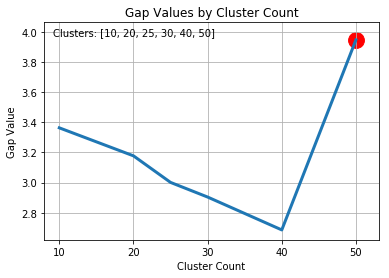

In [60]:
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.text(20, 4, 'Clusters: {}'.format(str(clustersToTest)), horizontalalignment='center',verticalalignment='center')
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.savefig('gap_statistic.png')
plt.show()

Compute clusters based off of the following features:
* s_location
* s_business_type
* t_location
* t_business_type
* weight, which is tokens exchange
* s_bal
* t_bal


"The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

The k-means algorithm divides a set of  samples  into  disjoint clusters , each described by the mean 
 of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from , although they live in the same space." - https://scikit-learn.org/stable/modules/clustering.html#k-means

In [13]:
kmeans = KMeans(n_clusters=50, random_state=1,n_jobs=-1).fit(updated.values)

/home/aclarkdata/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [14]:
# add the clusters back to the combined dataframe
combined['cluster'] = kmeans.labels_

/home/aclarkdata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
# add back the source and target variables
combined['source'] = source
combined['target'] = target

/home/aclarkdata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/aclarkdata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
combined.head()

,s_location,s_business_type,t_location,t_business_type,weight,s_bal,t_bal,cluster,source,target
0,GE Nairobi,Farming/Labour,GE Nairobi,Farming/Labour,9007.0,56.660892,11737.726002,13,0xC1697C1326fD192438515fE2F7E4cCb0C705C5d2,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31
1,GE Nairobi,Farming/Labour,Home,Farming/Labour,100.0,11737.726002,902.500000,12,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,0x4AB73CfaC1732a9DcD74BdB4C9605f21832D7C72
2,G.E,Farming/Labour,GE Nairobi,Farming/Labour,2.0,7297.262576,11737.726002,48,0xD95954e3fCd2f09A6Be5931D24f731eFa63BF435,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31
3,GE Nairobi,Farming/Labour,Home,Farming/Labour,23.0,11737.726002,902.500000,12,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31,0x4AB73CfaC1732a9DcD74BdB4C9605f21832D7C72
4,Test,Health,GE Nairobi,Farming/Labour,12.0,448.000000,11737.726002,13,0x4AfD04b9eD17759B362c8C929207Fe7ad81C39d3,0xBAB77A20a757e8438DfaBF01D5F36DD12d862B31


## Calculate and plot Two PCA components of the data.

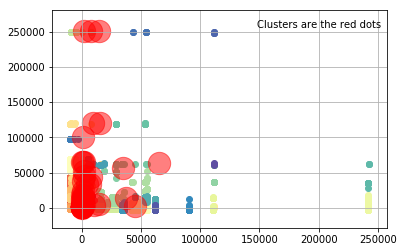

In [165]:
# Create a PCA instance: pca
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(updated
                                       )
df = pd.DataFrame(principalComponents)

df['label'] = kmeans.labels_
colors = plt.cm.Spectral(np.linspace(0, 1, len(df.label.unique())))

for color, label in zip(colors, df.label.unique()):
    
    tempdf = df[df.label == label]
    plt.scatter(tempdf[0], tempdf[1], c=color)
    
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], c='r', s=500, alpha=0.5,)
plt.grid(True)
plt.text(200000, 260000, 'Clusters are the red dots', horizontalalignment='center',verticalalignment='center')
plt.savefig('pca.png')
plt.show()

## Descriptive statistics 

Calculate relevant statistics, such as median, mean, etc for creating probability distributions in the subpopulation model.

In [17]:
combined.groupby('cluster').mean()

,weight,s_bal,t_bal
cluster,,,
0,217.737536,332.674357,3122.710726
1,588.111940,793.864819,251651.998315
2,957.820312,7089.179214,21755.181601
3,349.925309,516.042937,64166.491418
4,455.317844,64995.360511,751.148124
5,2443.890625,251651.998315,1746.597767
6,586.917409,1022.866799,38404.821609
7,1533.448040,23214.200804,1469.670862
8,408.100000,895.817336,100579.182676


In [18]:
# compute median, Q1,Q3, mean, and sigma
clustersMedianSourceBalance = []
clusters1stQSourceBalance = []
clusters3rdQSourceBalance = []
clustersMu = []
clustersSigma = []
for i in range(0,len(combined.cluster.unique())):
    temp = combined[combined['cluster']==i]
    clustersMu.append(round(temp.weight.mean(),2))
    clustersSigma.append(round(temp.weight.std(),2))
    clustersMedianSourceBalance.append(round(temp.weight.median(),2))
    clusters1stQSourceBalance.append(round(temp.s_bal.quantile(0.25),2))
    clusters3rdQSourceBalance.append(round(temp.s_bal.quantile(0.75),2))
    


In [23]:
clusters = []
for i in range(0,len(combined.cluster.unique())):
    clusters.append(str(i))
    
    
mixingAgents = clusters.copy()
mixingAgents.append('external')

In [26]:
UtilityTypesOrdered = {}
for i in range(0,len(combined.cluster.unique())):
    UtilityTypesOrdered[str(i)] = dict(zip(list(combined[combined['cluster']==i].t_business_type.value_counts(normalize=True).to_dict().keys()),list(combined[combined['cluster']==i].t_business_type.value_counts(normalize=True).to_dict().values())))
    
UtilityTypesOrdered['external'] =  {'Food/Water':1,
                                            'Fuel/Energy':2,
                                            'Health':3,
                                            'Education':4,
                                            'Savings Group':5,
                                            'Shop':6}


In [28]:
utilityTypesProbability = {}
for i in range(0,len(combined.cluster.unique())):
    utilityTypesProbability[str(i)] = combined[combined['cluster']==i].t_business_type.value_counts(normalize=True).to_dict()
    
    
utilityTypesProbability['external'] = {'Food/Water':0.6,
                                            'Fuel/Energy':0.10,
                                            'Health':0.03,
                                            'Education':0.015,
                                            'Savings Group':0.065,
                                            'Shop':0.19}


In [ ]:
# Create initilization file (copy from here) 

clusters = ['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49']

mixingAgents = ['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 'external']


clustersMedianSourceBalance = [150.0,
 340.0,
 250.0,
 20.0,
 330.0,
 320.0,
 240.0,
 300.0,
 300.0,
 50.0,
 900.0,
 120.0,
 400.0,
 180.0,
 300.0,
 6000.0,
 132.5,
 130.0,
 160.0,
 5000.0,
 150.0,
 10000.0,
 200.0,
 10000.0,
 200.0,
 200.0,
 35000.0,
 20000.0,
 100.0,
 500.0,
 425.0,
 13320.0,
 500.0,
 500.0,
 1000.0,
 390.0,
 150.0,
 250.0,
 45000.0,
 36300.0,
 960.0,
 120.0,
 200.0,
 100.0,
 220.0,
 600.0,
 62000.0,
 500.0,
 900.0,
 486.0]

clusters1stQSourceBalance = [56.0,
 118.46,
 105.0,
 64767.51,
 251652.0,
 124.5,
 4139.28,
 146.1,
 1002.5,
 17145.78,
 52676.2,
 100.0,
 121082.43,
 112.0,
 28849.43,
 27619.22,
 66.36,
 251652.0,
 148.0,
 38653.54,
 67.22,
 121082.43,
 6429.46,
 555.04,
 104.48,
 96.43,
 52676.2,
 251652.0,
 64.73,
 36824.5,
 15182.03,
 485.94,
 21660.89,
 11210.0,
 100579.18,
 100.46,
 2845.01,
 3338.98,
 1274.91,
 6724.88,
 38653.54,
 114.5,
 68.0,
 100.0,
 20.93,
 14050.3,
 63145.96,
 9276.23,
 63234.8,
 64767.51]

clusters3rdQSourceBalance = [403.96,
 506.6,
 592.96,
 64767.51,
 251652.0,
 1501.41,
 7214.9,
 869.82,
 1557.01,
 18304.36,
 55142.93,
 419.96,
 121082.43,
 816.3,
 38653.54,
 37106.89,
 770.65,
 251652.0,
 838.46,
 38653.54,
 315.0,
 121082.43,
 9074.79,
 5726.66,
 602.02,
 437.96,
 63234.8,
 251652.0,
 425.0,
 40953.15,
 17145.78,
 6349.27,
 25695.83,
 13156.46,
 100579.18,
 819.33,
 4158.5,
 5597.38,
 2823.81,
 20030.91,
 51710.52,
 537.94,
 542.92,
 415.43,
 895.66,
 18304.36,
 63145.96,
 14050.3,
 64767.51,
 64767.51]

clustersMu = [329.98,
 588.11,
 469.93,
 492.32,
 2443.89,
 565.21,
 1120.5,
 408.1,
 550.09,
 503.42,
 2478.89,
 349.93,
 9354.55,
 453.69,
 4298.1,
 7508.1,
 376.86,
 8074.0,
 333.75,
 7691.43,
 362.68,
 15562.5,
 672.28,
 10809.6,
 274.98,
 405.46,
 34555.56,
 14338.57,
 255.48,
 1229.44,
 1470.23,
 14590.61,
 1527.75,
 770.73,
 1039.05,
 503.7,
 362.11,
 499.51,
 45000.0,
 37504.55,
 1941.82,
 262.96,
 702.23,
 168.57,
 2000.58,
 1383.32,
 65333.33,
 1454.43,
 1483.11,
 1853.03]

clustersSigma = [583.23,
 1501.26,
 966.32,
 1452.2,
 6789.39,
 847.29,
 2228.12,
 483.5,
 852.2,
 1170.38,
 3256.26,
 1174.55,
 16235.99,
 841.35,
 7696.91,
 6814.68,
 785.21,
 10886.9,
 712.65,
 8713.11,
 708.54,
 18542.24,
 1164.0,
 3682.08,
 340.99,
 624.76,
 8171.77,
 15060.34,
 461.52,
 1774.39,
 4617.97,
 4770.82,
 2641.75,
 1133.41,
 767.87,
 437.68,
 652.72,
 761.07,
 7071.07,
 5274.96,
 2716.8,
 572.43,
 1553.21,
 210.61,
 4477.94,
 1798.73,
 31134.12,
 2147.9,
 1900.27,
 2909.68]


# nested dictionary
UtilityTypesOrdered = {'0': {'Food/Water': 0.4119323241317899,
  'Farming/Labour': 0.26090828138913624,
  'Shop': 0.17916295636687443,
  'Savings Group': 0.07266251113089937,
  'Fuel/Energy': 0.034194122885129116,
  'Transport': 0.02617987533392698,
  'Health': 0.006767586821015138,
  'Education': 0.004096170970614425,
  'None': 0.004096170970614425},
 '1': {'Food/Water': 1.0},
 '2': {'Savings Group': 0.87890625,
  'Health': 0.08984375,
  'Food/Water': 0.03125},
 '3': {'Savings Group': 0.4905964535196131,
  'Farming/Labour': 0.3610961848468565,
  'Food/Water': 0.14830736163353037},
 '4': {'Farming/Labour': 0.2843866171003718,
  'Shop': 0.25650557620817843,
  'Fuel/Energy': 0.17843866171003717,
  'Food/Water': 0.16171003717472118,
  'None': 0.10966542750929369,
  'Savings Group': 0.0055762081784386614,
  'Transport': 0.0037174721189591076},
 '5': {'Farming/Labour': 0.421875,
  'Food/Water': 0.421875,
  'Shop': 0.0625,
  'Savings Group': 0.03125,
  'Fuel/Energy': 0.03125,
  'Transport': 0.03125},
 '6': {'Savings Group': 0.6008097165991902,
  'Food/Water': 0.35870445344129553,
  'Shop': 0.04048582995951417},
 '7': {'Farming/Labour': 0.4346590909090909,
  'Food/Water': 0.2869318181818182,
  'Shop': 0.1278409090909091,
  'Fuel/Energy': 0.07670454545454546,
  'Savings Group': 0.03977272727272727,
  'Education': 0.017045454545454544,
  'None': 0.011363636363636364,
  'Transport': 0.002840909090909091,
  'Health': 0.002840909090909091},
 '8': {'Savings Group': 1.0},
 '9': {'Savings Group': 0.7142857142857143,
  'Food/Water': 0.18181818181818182,
  'Farming/Labour': 0.07792207792207792,
  'Education': 0.025974025974025976},
 '10': {'Food/Water': 0.3499875508340941,
  'Farming/Labour': 0.3162088140094614,
  'Shop': 0.21047389824881732,
  'Transport': 0.03950535314133953,
  'None': 0.03386173126400531,
  'Fuel/Energy': 0.022491493069964313,
  'Education': 0.01709685451074778,
  'Savings Group': 0.006473566271059839,
  'Environment': 0.002157855423686613,
  'Health': 0.0016598887874512407,
  'Chama': 8.299443937256204e-05},
 '11': {'Savings Group': 0.4873417721518987,
  'Food/Water': 0.3377445339470656,
  'Education': 0.09723820483314154,
  'Farming/Labour': 0.06271576524741082,
  'Shop': 0.014959723820483314},
 '12': {'Food/Water': 0.34994337485843713,
  'Shop': 0.2332955832389581,
  'Farming/Labour': 0.19592298980747452,
  'Fuel/Energy': 0.057757644394110984,
  'Savings Group': 0.053227633069082674,
  'Education': 0.05096262740656852,
  'None': 0.026047565118912798,
  'Transport': 0.020385050962627407,
  'Health': 0.011325028312570781,
  'Environment': 0.0011325028312570782},
 '13': {'Savings Group': 0.3712871287128713,
  'Food/Water': 0.247974797479748,
  'Shop': 0.19801980198019803,
  'Fuel/Energy': 0.08235823582358236,
  'Health': 0.07605760576057606,
  'Farming/Labour': 0.024302430243024302},
 '14': {'Savings Group': 1.0},
 '15': {'Savings Group': 1.0},
 '16': {'Savings Group': 0.5, 'Food/Water': 0.5},
 '17': {'Savings Group': 0.7335701598579041,
  'Shop': 0.17584369449378331,
  'Food/Water': 0.0905861456483126},
 '18': {'Savings Group': 0.6984126984126984,
  'Food/Water': 0.23809523809523808,
  'Farming/Labour': 0.06349206349206349},
 '19': {'Savings Group': 1.0},
 '20': {'Savings Group': 1.0},
 '21': {'Farming/Labour': 0.47619047619047616,
  'Food/Water': 0.3333333333333333,
  'Shop': 0.09523809523809523,
  'Fuel/Energy': 0.047619047619047616,
  'Transport': 0.047619047619047616},
 '22': {'Food/Water': 0.33040588654165676,
  'Farming/Labour': 0.3209114645145977,
  'Shop': 0.164016140517446,
  'None': 0.06147638262520769,
  'Fuel/Energy': 0.05008307619273677,
  'Transport': 0.028957987182530263,
  'Savings Group': 0.023973415618324233,
  'Education': 0.014478993591265131,
  'Health': 0.0035604082601471635,
  'Environment': 0.0011868027533823878,
  'Staff': 0.00047472110135295516,
  'Chama': 0.00023736055067647758,
  'Game': 0.00023736055067647758},
 '23': {'Savings Group': 0.8323424494649228,
  'Farming/Labour': 0.16765755053507728},
 '24': {'Farming/Labour': 0.38481675392670156,
  'Food/Water': 0.3717277486910995,
  'Shop': 0.1387434554973822,
  'Fuel/Energy': 0.05235602094240838,
  'Transport': 0.02356020942408377,
  'Savings Group': 0.01832460732984293,
  'Education': 0.007853403141361256,
  'Staff': 0.002617801047120419},
 '25': {'Savings Group': 0.7916666666666666,
  'Food/Water': 0.20833333333333334},
 '26': {'Savings Group': 0.7442348008385744, 'Food/Water': 0.2557651991614256},
 '27': {'Food/Water': 0.3333333333333333,
  'Farming/Labour': 0.25,
  'Health': 0.25,
  'Savings Group': 0.08333333333333333,
  'Fuel/Energy': 0.08333333333333333},
 '28': {'Food/Water': 1.0},
 '29': {'Food/Water': 0.27335640138408307,
  'Farming/Labour': 0.23529411764705882,
  'Shop': 0.21972318339100347,
  'Fuel/Energy': 0.21280276816608998,
  'None': 0.03806228373702422,
  'Education': 0.006920415224913495,
  'Transport': 0.006920415224913495,
  'Savings Group': 0.005190311418685121,
  'Staff': 0.0017301038062283738},
 '30': {'Food/Water': 0.36228287841191065,
  'Shop': 0.2679900744416873,
  'Farming/Labour': 0.21712158808933002,
  'Savings Group': 0.08436724565756824,
  'Education': 0.02481389578163772,
  'Fuel/Energy': 0.018610421836228287,
  'Transport': 0.017369727047146403,
  'None': 0.0037220843672456576,
  'Health': 0.0024813895781637717,
  'Environment': 0.0012406947890818859},
 '31': {'Savings Group': 0.8,
  'Food/Water': 0.13333333333333333,
  'Shop': 0.06666666666666667},
 '32': {'Savings Group': 0.7444444444444445,
  'Farming/Labour': 0.2,
  'Food/Water': 0.05555555555555555},
 '33': {'Food/Water': 0.33343474292668085,
  'Farming/Labour': 0.28414968055978096,
  'Savings Group': 0.18892607240644965,
  'Shop': 0.1146942500760572,
  'Fuel/Energy': 0.06936416184971098,
  'None': 0.006693033160937024,
  'Education': 0.0027380590203833284},
 '34': {'Savings Group': 1.0},
 '35': {'Food/Water': 0.3829787234042553,
  'Farming/Labour': 0.2390488110137672,
  'Shop': 0.1902377972465582,
  'Savings Group': 0.07259073842302878,
  'Transport': 0.060075093867334166,
  'Health': 0.030037546933667083,
  'Fuel/Energy': 0.016270337922403004,
  'None': 0.0050062578222778474,
  'Education': 0.0037546933667083854},
 '36': {'Savings Group': 1.0},
 '37': {'Farming/Labour': 0.5454545454545454,
  'Food/Water': 0.36363636363636365,
  'Savings Group': 0.045454545454545456,
  'Shop': 0.045454545454545456},
 '38': {'Savings Group': 1.0},
 '39': {'Savings Group': 1.0},
 '40': {'Farming/Labour': 0.3595236417447678,
  'Food/Water': 0.3165386512578395,
  'Shop': 0.18842928616728913,
  'Fuel/Energy': 0.05108871820167712,
  'None': 0.0360439715312522,
  'Transport': 0.022443802409978154,
  'Education': 0.01039391163413431,
  'Savings Group': 0.00842083010358678,
  'Health': 0.004545134240011275,
  'Staff': 0.0011627087590726517,
  'Environment': 0.0010570079627933197,
  'System': 0.00035233598759777326},
 '41': {'Food/Water': 0.33003300330033003,
  'Farming/Labour': 0.2739273927392739,
  'Shop': 0.1782178217821782,
  'Savings Group': 0.13861386138613863,
  'Health': 0.0429042904290429,
  'Fuel/Energy': 0.0165016501650165,
  'Transport': 0.0165016501650165,
  'Education': 0.0033003300330033004},
 '42': {'Savings Group': 0.8661740558292282, 'Health': 0.13382594417077176},
 '43': {'Savings Group': 1.0},
 '44': {'Food/Water': 0.4805194805194805,
  'Shop': 0.14285714285714285,
  'Savings Group': 0.14285714285714285,
  'Farming/Labour': 0.13636363636363635,
  'Health': 0.06493506493506493,
  'Transport': 0.012987012987012988,
  'Environment': 0.012987012987012988,
  'Fuel/Energy': 0.006493506493506494},
 '45': {'Food/Water': 0.35471100554235946,
  'Farming/Labour': 0.2414885193982581,
  'Shop': 0.23198733174980204,
  'Education': 0.03800475059382423,
  'None': 0.035629453681710214,
  'Transport': 0.035629453681710214,
  'Fuel/Energy': 0.028503562945368172,
  'Savings Group': 0.02454473475851148,
  'Health': 0.006334125098970704,
  'Environment': 0.001583531274742676,
  'Staff': 0.000791765637371338,
  'System': 0.000791765637371338},
 '46': {'Savings Group': 0.6981132075471698,
  'Health': 0.18867924528301888,
  'Food/Water': 0.09433962264150944,
  'Shop': 0.018867924528301886},
 '47': {'Savings Group': 0.5555555555555556,
  'Farming/Labour': 0.2222222222222222,
  'Food/Water': 0.2222222222222222},
 '48': {'Food/Water': 0.38795180722891565,
  'Savings Group': 0.38313253012048193,
  'Health': 0.10120481927710843,
  'Shop': 0.09879518072289156,
  'Fuel/Energy': 0.016867469879518072,
  'Farming/Labour': 0.012048192771084338},
 '49': {'Food/Water': 0.3829787234042553,
  'Savings Group': 0.3829787234042553,
  'Education': 0.19148936170212766,
  'Fuel/Energy': 0.0425531914893617},
 'external': {'Food/Water': 1,
  'Fuel/Energy': 2,
  'Health': 3,
  'Education': 4,
  'Savings Group': 5,
  'Shop': 6}}
    
#  nested dictionary 
utilityTypesProbability = {'0': {'Food/Water': 0.4119323241317899,
  'Farming/Labour': 0.26090828138913624,
  'Shop': 0.17916295636687443,
  'Savings Group': 0.07266251113089937,
  'Fuel/Energy': 0.034194122885129116,
  'Transport': 0.02617987533392698,
  'Health': 0.006767586821015138,
  'Education': 0.004096170970614425,
  'None': 0.004096170970614425},
 '1': {'Food/Water': 1.0},
 '2': {'Savings Group': 0.87890625,
  'Health': 0.08984375,
  'Food/Water': 0.03125},
 '3': {'Savings Group': 0.4905964535196131,
  'Farming/Labour': 0.3610961848468565,
  'Food/Water': 0.14830736163353037},
 '4': {'Farming/Labour': 0.2843866171003718,
  'Shop': 0.25650557620817843,
  'Fuel/Energy': 0.17843866171003717,
  'Food/Water': 0.16171003717472118,
  'None': 0.10966542750929369,
  'Savings Group': 0.0055762081784386614,
  'Transport': 0.0037174721189591076},
 '5': {'Farming/Labour': 0.421875,
  'Food/Water': 0.421875,
  'Shop': 0.0625,
  'Savings Group': 0.03125,
  'Fuel/Energy': 0.03125,
  'Transport': 0.03125},
 '6': {'Savings Group': 0.6008097165991902,
  'Food/Water': 0.35870445344129553,
  'Shop': 0.04048582995951417},
 '7': {'Farming/Labour': 0.4346590909090909,
  'Food/Water': 0.2869318181818182,
  'Shop': 0.1278409090909091,
  'Fuel/Energy': 0.07670454545454546,
  'Savings Group': 0.03977272727272727,
  'Education': 0.017045454545454544,
  'None': 0.011363636363636364,
  'Transport': 0.002840909090909091,
  'Health': 0.002840909090909091},
 '8': {'Savings Group': 1.0},
 '9': {'Savings Group': 0.7142857142857143,
  'Food/Water': 0.18181818181818182,
  'Farming/Labour': 0.07792207792207792,
  'Education': 0.025974025974025976},
 '10': {'Food/Water': 0.3499875508340941,
  'Farming/Labour': 0.3162088140094614,
  'Shop': 0.21047389824881732,
  'Transport': 0.03950535314133953,
  'None': 0.03386173126400531,
  'Fuel/Energy': 0.022491493069964313,
  'Education': 0.01709685451074778,
  'Savings Group': 0.006473566271059839,
  'Environment': 0.002157855423686613,
  'Health': 0.0016598887874512407,
  'Chama': 8.299443937256204e-05},
 '11': {'Savings Group': 0.4873417721518987,
  'Food/Water': 0.3377445339470656,
  'Education': 0.09723820483314154,
  'Farming/Labour': 0.06271576524741082,
  'Shop': 0.014959723820483314},
 '12': {'Food/Water': 0.34994337485843713,
  'Shop': 0.2332955832389581,
  'Farming/Labour': 0.19592298980747452,
  'Fuel/Energy': 0.057757644394110984,
  'Savings Group': 0.053227633069082674,
  'Education': 0.05096262740656852,
  'None': 0.026047565118912798,
  'Transport': 0.020385050962627407,
  'Health': 0.011325028312570781,
  'Environment': 0.0011325028312570782},
 '13': {'Savings Group': 0.3712871287128713,
  'Food/Water': 0.247974797479748,
  'Shop': 0.19801980198019803,
  'Fuel/Energy': 0.08235823582358236,
  'Health': 0.07605760576057606,
  'Farming/Labour': 0.024302430243024302},
 '14': {'Savings Group': 1.0},
 '15': {'Savings Group': 1.0},
 '16': {'Savings Group': 0.5, 'Food/Water': 0.5},
 '17': {'Savings Group': 0.7335701598579041,
  'Shop': 0.17584369449378331,
  'Food/Water': 0.0905861456483126},
 '18': {'Savings Group': 0.6984126984126984,
  'Food/Water': 0.23809523809523808,
  'Farming/Labour': 0.06349206349206349},
 '19': {'Savings Group': 1.0},
 '20': {'Savings Group': 1.0},
 '21': {'Farming/Labour': 0.47619047619047616,
  'Food/Water': 0.3333333333333333,
  'Shop': 0.09523809523809523,
  'Fuel/Energy': 0.047619047619047616,
  'Transport': 0.047619047619047616},
 '22': {'Food/Water': 0.33040588654165676,
  'Farming/Labour': 0.3209114645145977,
  'Shop': 0.164016140517446,
  'None': 0.06147638262520769,
  'Fuel/Energy': 0.05008307619273677,
  'Transport': 0.028957987182530263,
  'Savings Group': 0.023973415618324233,
  'Education': 0.014478993591265131,
  'Health': 0.0035604082601471635,
  'Environment': 0.0011868027533823878,
  'Staff': 0.00047472110135295516,
  'Chama': 0.00023736055067647758,
  'Game': 0.00023736055067647758},
 '23': {'Savings Group': 0.8323424494649228,
  'Farming/Labour': 0.16765755053507728},
 '24': {'Farming/Labour': 0.38481675392670156,
  'Food/Water': 0.3717277486910995,
  'Shop': 0.1387434554973822,
  'Fuel/Energy': 0.05235602094240838,
  'Transport': 0.02356020942408377,
  'Savings Group': 0.01832460732984293,
  'Education': 0.007853403141361256,
  'Staff': 0.002617801047120419},
 '25': {'Savings Group': 0.7916666666666666,
  'Food/Water': 0.20833333333333334},
 '26': {'Savings Group': 0.7442348008385744, 'Food/Water': 0.2557651991614256},
 '27': {'Food/Water': 0.3333333333333333,
  'Farming/Labour': 0.25,
  'Health': 0.25,
  'Savings Group': 0.08333333333333333,
  'Fuel/Energy': 0.08333333333333333},
 '28': {'Food/Water': 1.0},
 '29': {'Food/Water': 0.27335640138408307,
  'Farming/Labour': 0.23529411764705882,
  'Shop': 0.21972318339100347,
  'Fuel/Energy': 0.21280276816608998,
  'None': 0.03806228373702422,
  'Education': 0.006920415224913495,
  'Transport': 0.006920415224913495,
  'Savings Group': 0.005190311418685121,
  'Staff': 0.0017301038062283738},
 '30': {'Food/Water': 0.36228287841191065,
  'Shop': 0.2679900744416873,
  'Farming/Labour': 0.21712158808933002,
  'Savings Group': 0.08436724565756824,
  'Education': 0.02481389578163772,
  'Fuel/Energy': 0.018610421836228287,
  'Transport': 0.017369727047146403,
  'None': 0.0037220843672456576,
  'Health': 0.0024813895781637717,
  'Environment': 0.0012406947890818859},
 '31': {'Savings Group': 0.8,
  'Food/Water': 0.13333333333333333,
  'Shop': 0.06666666666666667},
 '32': {'Savings Group': 0.7444444444444445,
  'Farming/Labour': 0.2,
  'Food/Water': 0.05555555555555555},
 '33': {'Food/Water': 0.33343474292668085,
  'Farming/Labour': 0.28414968055978096,
  'Savings Group': 0.18892607240644965,
  'Shop': 0.1146942500760572,
  'Fuel/Energy': 0.06936416184971098,
  'None': 0.006693033160937024,
  'Education': 0.0027380590203833284},
 '34': {'Savings Group': 1.0},
 '35': {'Food/Water': 0.3829787234042553,
  'Farming/Labour': 0.2390488110137672,
  'Shop': 0.1902377972465582,
  'Savings Group': 0.07259073842302878,
  'Transport': 0.060075093867334166,
  'Health': 0.030037546933667083,
  'Fuel/Energy': 0.016270337922403004,
  'None': 0.0050062578222778474,
  'Education': 0.0037546933667083854},
 '36': {'Savings Group': 1.0},
 '37': {'Farming/Labour': 0.5454545454545454,
  'Food/Water': 0.36363636363636365,
  'Savings Group': 0.045454545454545456,
  'Shop': 0.045454545454545456},
 '38': {'Savings Group': 1.0},
 '39': {'Savings Group': 1.0},
 '40': {'Farming/Labour': 0.3595236417447678,
  'Food/Water': 0.3165386512578395,
  'Shop': 0.18842928616728913,
  'Fuel/Energy': 0.05108871820167712,
  'None': 0.0360439715312522,
  'Transport': 0.022443802409978154,
  'Education': 0.01039391163413431,
  'Savings Group': 0.00842083010358678,
  'Health': 0.004545134240011275,
  'Staff': 0.0011627087590726517,
  'Environment': 0.0010570079627933197,
  'System': 0.00035233598759777326},
 '41': {'Food/Water': 0.33003300330033003,
  'Farming/Labour': 0.2739273927392739,
  'Shop': 0.1782178217821782,
  'Savings Group': 0.13861386138613863,
  'Health': 0.0429042904290429,
  'Fuel/Energy': 0.0165016501650165,
  'Transport': 0.0165016501650165,
  'Education': 0.0033003300330033004},
 '42': {'Savings Group': 0.8661740558292282, 'Health': 0.13382594417077176},
 '43': {'Savings Group': 1.0},
 '44': {'Food/Water': 0.4805194805194805,
  'Shop': 0.14285714285714285,
  'Savings Group': 0.14285714285714285,
  'Farming/Labour': 0.13636363636363635,
  'Health': 0.06493506493506493,
  'Transport': 0.012987012987012988,
  'Environment': 0.012987012987012988,
  'Fuel/Energy': 0.006493506493506494},
 '45': {'Food/Water': 0.35471100554235946,
  'Farming/Labour': 0.2414885193982581,
  'Shop': 0.23198733174980204,
  'Education': 0.03800475059382423,
  'None': 0.035629453681710214,
  'Transport': 0.035629453681710214,
  'Fuel/Energy': 0.028503562945368172,
  'Savings Group': 0.02454473475851148,
  'Health': 0.006334125098970704,
  'Environment': 0.001583531274742676,
  'Staff': 0.000791765637371338,
  'System': 0.000791765637371338},
 '46': {'Savings Group': 0.6981132075471698,
  'Health': 0.18867924528301888,
  'Food/Water': 0.09433962264150944,
  'Shop': 0.018867924528301886},
 '47': {'Savings Group': 0.5555555555555556,
  'Farming/Labour': 0.2222222222222222,
  'Food/Water': 0.2222222222222222},
 '48': {'Food/Water': 0.38795180722891565,
  'Savings Group': 0.38313253012048193,
  'Health': 0.10120481927710843,
  'Shop': 0.09879518072289156,
  'Fuel/Energy': 0.016867469879518072,
  'Farming/Labour': 0.012048192771084338},
 '49': {'Food/Water': 0.3829787234042553,
  'Savings Group': 0.3829787234042553,
  'Education': 0.19148936170212766,
  'Fuel/Energy': 0.0425531914893617},
 'external': {'Food/Water': 0.6,
  'Fuel/Energy': 0.1,
  'Health': 0.03,
  'Education': 0.015,
  'Savings Group': 0.065,
  'Shop': 0.19}}

# agent:[centrality,allocationValue]
agentAllocation = {'0': [1, 1],
 '1': [1, 1],
 '2': [1, 1],
 '3': [1, 1],
 '4': [1, 1],
 '5': [1, 1],
 '6': [1, 1],
 '7': [1, 1],
 '8': [1, 1],
 '9': [1, 1],
 '10': [1, 1],
 '11': [1, 1],
 '12': [1, 1],
 '13': [1, 1],
 '14': [1, 1],
 '15': [1, 1],
 '16': [1, 1],
 '17': [1, 1],
 '18': [1, 1],
 '19': [1, 1],
 '20': [1, 1],
 '21': [1, 1],
 '22': [1, 1],
 '23': [1, 1],
 '24': [1, 1],
 '25': [1, 1],
 '26': [1, 1],
 '27': [1, 1],
 '28': [1, 1],
 '29': [1, 1],
 '30': [1, 1],
 '31': [1, 1],
 '32': [1, 1],
 '33': [1, 1],
 '34': [1, 1],
 '35': [1, 1],
 '36': [1, 1],
 '37': [1, 1],
 '38': [1, 1],
 '39': [1, 1],
 '40': [1, 1],
 '41': [1, 1],
 '42': [1, 1],
 '43': [1, 1],
 '44': [1, 1],
 '45': [1, 1],
 '46': [1, 1],
 '47': [1, 1],
 '48': [1, 1],
 '49': [1, 1]}
